In [1]:
import numpy as np
from utils.optlib.Solver import *

In [4]:
# setting the underlying
stock = Underlying(price=65, volatility=0.3)
# creating the European Put option
EuPut = Option(call=False, strike=50)
# creating the grid and adding option's parameters
solver = Solver(underlying=stock,
                option=EuPut,
                xSteps=300,
                tSteps=200)
solver.solve_crank_nickolson()

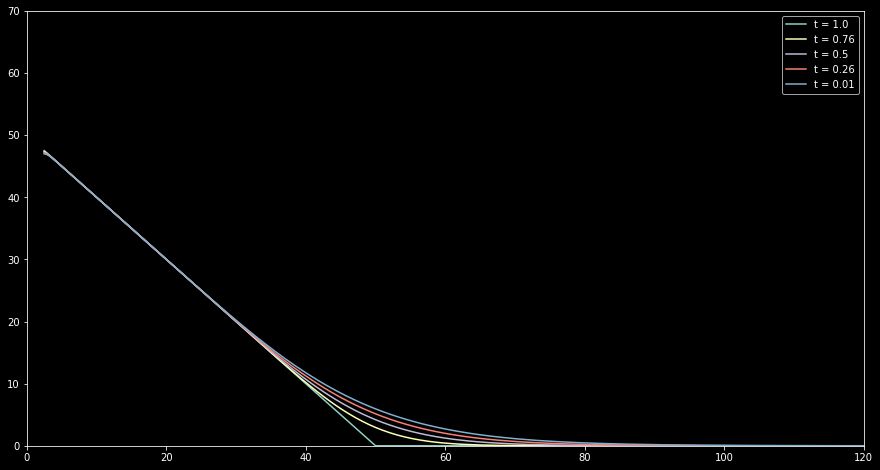

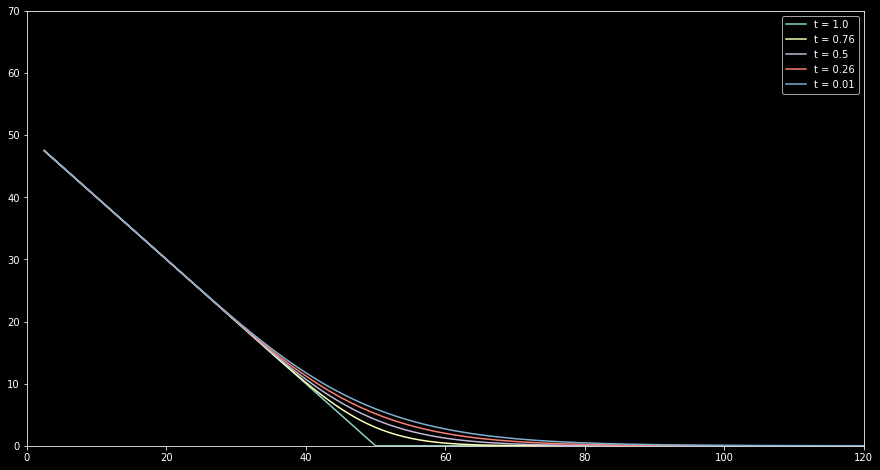

In [5]:
solver.plot(cut=True, mod=Mode.NORM)
solver.plot(cut=True, mod=Mode.BSM)

### Vega

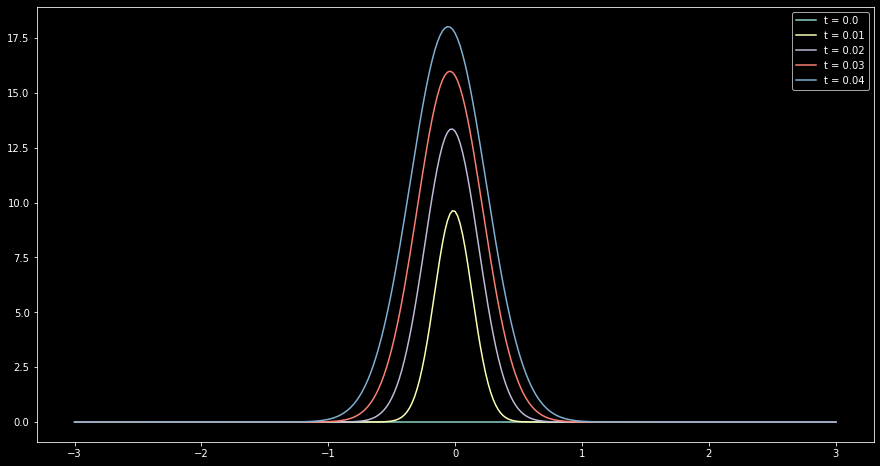

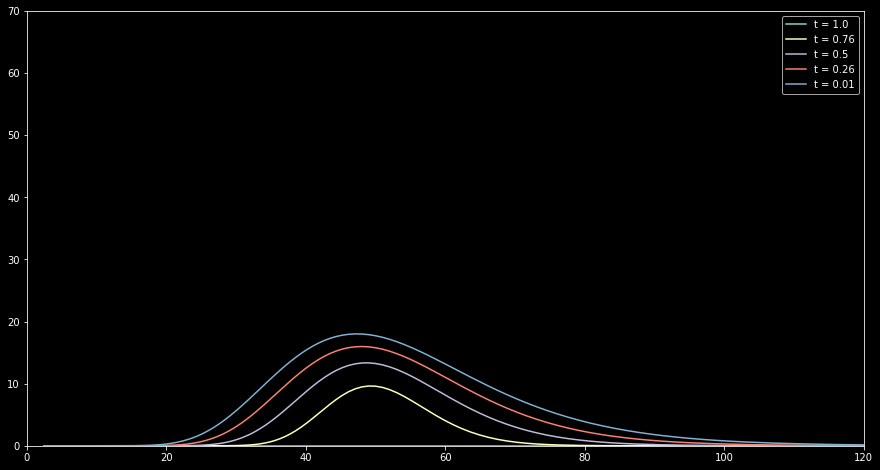

In [10]:
solver.plot(cut=False, mod=Mode.VEGA_HEAT)
solver.plot(cut=True, mod=Mode.VEGA)


### Forward $y(x, \tau)$ and $dy/d\sigma$ computation

In [11]:
# for Vega
A, B = get_matricies(grid0.xSteps, grid0.lamda)

N = grid0.tSteps
M = grid0.xSteps
A_inv = np.linalg.inv(A)
Vega = np.empty((M+1, N+1))

def Y_sigma(time_ind, x_array):
    x = x_array[0]
    t = grid0.tGrid[time_ind]
    coef = -2 * stock.interest / stock.volatility**3

    y_sigma = coef * np.multiply(net0[:,0],  x_array)
    y_sigma[0] = coef * opt.g_func(grid0.q, t, x) * (x + (grid0.q + 1) * t)
    return y_sigma

lambda_sigma = stock.volatility * grid0.option.maturity * (M+1)**2 / ((N+1) * (grid0.xRight - grid0.xLeft)**2)
A_sigma = np.diag(2 * np.ones(M+1))
for i in range(1, M + 1):
    A[i, i-1] = -1
    A[i-1, i] = -1
A_sigma = A_sigma * lambda_sigma / 2
A_sigma[0,0] = 0
A_sigma[M,M] = 0
A_sigma[0,1] = 0
A_sigma[M,M-1] = 0

B_sigma = -A_sigma

NameError: name 'get_matricies' is not defined

In [ ]:
# fwd vega calculation
Vega[:,0] = Y_sigma(0, grid0.xGrid.copy())

for i in np.arange(0, grid0.tSteps):
    Vega[:,i+1] = np.dot(A_inv, B_sigma @ net0[:,i] - A_sigma @ net0[:,i+1] + B @ Vega[:,i])

In [ ]:
vega_grid = opt.Grid(xSteps=300,
                tSteps=200,
                xLeft=-3.0,
                xRight=3.0)

vega_grid.addOption(EuPut)
vega_grid.net = Vega[:250,:]
# vega_grid.toNormal(obj_mutation=True)
vega_grid.plot(0, cut=False, border=0.05)

### Adjoint $\lambda^{T}$ computation (backward loop)

In [ ]:
N = grid.tSteps
M = grid.xSteps

lambda_vec = np.empty((M+1, N+1))
lambda_vec[:,N] = np.ones(M+1)

A_inv = np.linalg.inv(A)
f_y = np.dot(A_inv, B)

for i in range(N, 1, -1):
    lambda_vec[:, i-1] = np.dot(f_y, lambda_vec[:,i])

### Adjoint Vega calculation (forward loop)

In [ ]:
lambda_sigma = stock.volatility * grid.option.maturity * (M+1)**2 / ((N+1) * (grid.xRight - grid.xLeft)**2)
A_sigma = np.diag(2 * np.ones(M+1))
for i in range(1, M + 1):
    A[i, i-1] = -1
    A[i-1, i] = -1
A_sigma = A_sigma * lambda_sigma / 2
B_sigma = -A_sigma

In [ ]:
Vega = np.empty((M+1, N+1))

x_vec =  grid.xGrid.copy()
y0_sigma = np.multiply(net[:,0], -2 * x_vec * stock.interest / stock.volatility**3)
Vega[:,0] = np.multiply(lambda_vec[:,0], y0_sigma)

def d_sigma(ind):
    x = grid.xGrid[0]
    t1 = grid.tGrid[ind]
    t2 = grid.tGrid[ind+1]
    q = grid.q

    el1 = opt.g_func(q, t1, x) + opt.g_func(q, t2, x)
    el2 = t1 * opt.g_func(q, t1, x) + t2 * opt.g_func(q, t2, x)

    d1 = el1 * lambda_sigma / 2
    d2 = (- 2 * stock.interest / stock.volatility**3) * (el1 * x + (q+1) * el2)
    return d1 + d2

# Adjoint vector of linear system
lambda_linear = np.dot(A_inv, np.ones(M+1))
for i in range(1, N+1):
    # linear system adjoint solving (finding foo_sigma)
    d_sigma_vec = np.zeros(M+1)
    d_sigma_vec[0] = d_sigma(i-1)
    something = B_sigma @ net[:,i-1] + B @ Vega[:,i-1] + d_sigma_vec - A_sigma @ net[:,i]
    foo_sigma = np.multiply(lambda_linear, something)

    Vega[:,i] = Vega[:,i-1] + np.multiply(lambda_vec[:,i], foo_sigma)

In [ ]:
grid.net = Vega.copy()
grid.plot(0, cut=True)